In [1]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


# Import packages

In [3]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import to load arff file from url
from scipy.io import arff
import urllib.request
import io 

# Sklearn import
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Normalization and standard scaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Label and 1-hot encoding
from sklearn.linear_model import LogisticRegression # Logistic regression model
from sklearn.linear_model import LogisticRegressionCV # Logistic regression with cross-validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score  # Accuracy
from sklearn.metrics import confusion_matrix # Confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score  # Precision, recall, and f1 score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mariana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import os
os.system('pip install spacy')
#os.system('python -m spacy download fr_core_news_sm')


0

In [5]:
import spacy
import string
nlp = spacy.load('fr_core_news_sm')

# Read data

In [7]:
# Training data
training = pd.read_csv('https://github.com/cvermno/ML-Project/raw/main/Datasets/training_data.csv')
# Test data
test = pd.read_csv('https://github.com/cvermno/ML-Project/raw/main/Datasets/unlabelled_test_data.csv')

## Getting to know the data

In [9]:
training

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...,...
4795,4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,4797,"Et le premier samedi de chaque mois, venez ren...",A2
4798,4798,Les coûts liés à la journalisation n'étant pas...,C2


### Exploring the base rate

In [11]:
training_difficulty = training['difficulty'].value_counts()
training_difficulty_100 = training['difficulty'].value_counts(normalize=True)*100
print(training_difficulty)
print(training_difficulty_100)

difficulty
A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: count, dtype: int64
difficulty
A1    16.9375
C2    16.8125
C1    16.6250
B1    16.5625
A2    16.5625
B2    16.5000
Name: proportion, dtype: float64


In [12]:
test

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."
...,...,...
1195,1195,C'est un phénomène qui trouve une accélération...
1196,1196,Je vais parler au serveur et voir si on peut d...
1197,1197,Il n'était pas comme tant de gens qui par pare...
1198,1198,Ils deviennent dangereux pour notre économie.


In [13]:
labels = training['difficulty'].unique().tolist()
labels

['C1', 'A1', 'B1', 'A2', 'B2', 'C2']

# Tokenizing and Lemmatization

In [15]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = stopwords.words('french')
    punctuations = string.punctuation +'–' + '—'
    numbers = "0123456789"

    # Create spacy object
    mytokens = nlp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = ([ word.lemma_.lower().strip() for word in mytokens ])

    # Remove stop words and punctuation
    mytokens = ([ word for word in mytokens 
                 if word not in stop_words and word not in punctuations ])

    # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
        for char in word:
            if (char in punctuations) or (char in numbers):
                word = word.replace(char, "")
        if word != "":
            mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2


In [16]:
# Tokenize texts in training and test data sets
#processed_texts = [spacy_tokenizer(text) for text in texts]
training['processed_sentence'] = training['sentence'].apply(spacy_tokenizer)
training['processed_sentence'] = training['processed_sentence'].apply(lambda x: ' '.join(x))
training.head(5)
#for processed_text in processed_texts:
#    print(processed_text[:20])

,id,sentence,difficulty,processed_sentence
0,0,Les coûts kilométriques réels peuvent diverger...,C1,coût kilométrique réel pouvoir diverger sensib...
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,bleu être couleur préférer aimer vert
2,2,Le test de niveau en français est sur le site ...,A1,test niveau français être site internet école
3,3,Est-ce que ton mari est aussi de Boston?,A1,ce mari être aussi boston
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,école commerce couloir place financier arriver...


In [17]:
test['processed_sentence'] = test['sentence'].apply(spacy_tokenizer)
test['processed_sentence'] = test['processed_sentence'].apply(lambda x: ' '.join(x))
test.head(5)

,id,sentence,processed_sentence
0,0,Nous dûmes nous excuser des propos que nous eû...,dûme excuser propos avoir prononcer
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...,pouvoir savoir plaisir avoir recevoir bon nouveau
2,2,"Et, paradoxalement, boire froid n'est pas la b...",paradoxalement boire froid être bon parade
3,3,"Ce n'est pas étonnant, car c'est une saison my...",être étonnant car être saison mystérieux
4,4,"Le corps de Golo lui-même, d'une essence aussi...",corps golo luimême essence aussi surnaturel ce...


### Split and transform

In [19]:
# split your data into features (X) and target variable (y)
X = training['processed_sentence']
y = training['difficulty']

In [20]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 123)

In [21]:
# vectorization
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#french_stop_words = stopwords.words('french')

#tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=french_stop_words)
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regresssion

Logistic Regression predicts binary outcomes by estimating probabilities using a logistic function. It fits a curve to decide classes. Example: Predicting whether an email is spam.

In [24]:
#from sklearn.linear_model import LogisticRegression

# initialize and train the Logistic Regression model
model_LR = LogisticRegression()
model_LR.fit(X_train_tfidf, y_train)

LogisticRegression()

In [25]:
# predict using the trained model on the scaled test data
y_pred_LR = model_LR.predict(X_test_tfidf)

In [26]:
# display y_pred values for each X_test
df_pred_LR = pd.DataFrame({'id': X_test.index, 'difficulty': y_pred_LR})
df_pred_LR

,id,difficulty
0,3902,A1
1,2862,A2
2,3473,B1
3,4423,A1
4,608,A2
...,...,...
955,1582,A1
956,1144,B1
957,790,A2
958,80,B2


### Evaluate the model

In [28]:
# calculate the test accuracy
accuracy_test_LR = accuracy_score(y_test, y_pred_LR)
print(f'Accurary of Logistic regression classifier on test set: {accuracy_test_LR :.2f}')

Accurary of Logistic regression classifier on test set: 0.44


In [29]:
# display the classification report
print(classification_report(y_test,y_pred_LR))

              precision    recall  f1-score   support

          A1       0.49      0.55      0.52       153
          A2       0.39      0.41      0.40       156
          B1       0.35      0.44      0.39       153
          B2       0.49      0.28      0.36       173
          C1       0.47      0.37      0.42       166
          C2       0.46      0.57      0.51       159

    accuracy                           0.44       960
   macro avg       0.44      0.44      0.43       960
weighted avg       0.44      0.44      0.43       960



In [30]:
# record the macro avg values the precision, recall, F1-score
precision_LR = precision_score(y_test, y_pred_LR, average='macro')
print("Precision:", precision_LR)

recall_LR = recall_score(y_test, y_pred_LR, average='macro')
print("Recall:", recall_LR)

f1_LR = f1_score(y_test, y_pred_LR, average='macro')
print("F1-score:", f1_LR)

Precision: 0.441007199625221
Recall: 0.43879641278206954
F1-score: 0.4322619042094431


<Figure size 800x600 with 0 Axes>

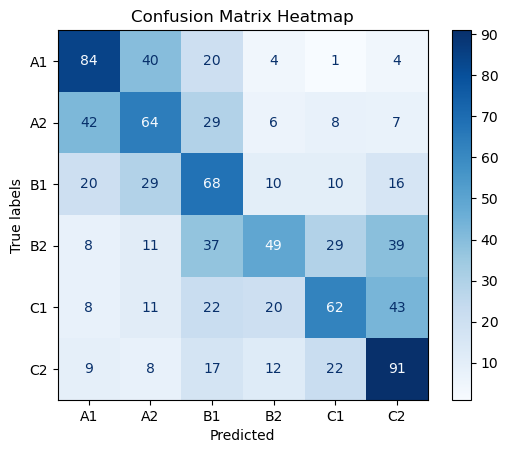

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_LR)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='g')
plt.xlabel('Predicted')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


### Train on the full training data, test on the unlabelled test data

In [33]:
# split your data into features (X) and target variable (y)
X = training['processed_sentence']
y = training['difficulty']

# define test data
X_full_test = test['processed_sentence']

# vectorization
#tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=french_stop_words)
#tfidf = TfidfVectorizer()
X_full_train_tfidf = tfidf.fit_transform(X)
X_full_test_tfidf = tfidf.transform(X_full_test)

In [34]:
# initialize and train the Logistic Regression model
model_LR_full = LogisticRegression()
model_LR_full.fit(X_full_train_tfidf, y)

LogisticRegression()

In [35]:
# predict using the trained model on the scaled test data
y_full_pred_LR = model_LR_full.predict(X_full_test_tfidf)

In [36]:
# display y_full_pred values for each X
df_full_pred_LR = pd.DataFrame({'id': X_full_test.index, 'difficulty': y_full_pred_LR})
df_full_pred_LR

,id,difficulty
0,0,B1
1,1,B1
2,2,A1
3,3,A1
4,4,C2
...,...,...
1195,1195,A2
1196,1196,A2
1197,1197,C2
1198,1198,C2


### Export the df as csv for kagle submission

In [38]:
# Export the dataframe as csv
df_full_pred_LR.to_csv("df_LR_lemma.csv", index=False)

# Accuracy score based on kagel submission: [df_LR : 0.455,df_LR_lemma : 0.436, 

# 2. Decision Tree

Decision Tree splits data by features to make decisions, forming a tree structure. Each node represents a decision point. Example: Loan approval based on financial history.

### Train on 80% of training data, test on 20% of training data

In [42]:
# Initialize the Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier(max_depth=10, random_state=123)

# Train the Decision Tree classifier on the training data
decision_tree_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred_dt = decision_tree_classifier.predict(X_test_tfidf)

In [43]:
# display y_pred values for each X_test
df_pred_dt = pd.DataFrame({'id': X_test.index, 'difficulty': y_pred_dt})
df_pred_dt

,id,difficulty
0,3902,A1
1,2862,A1
2,3473,B1
3,4423,B1
4,608,A1
...,...,...
955,1582,A1
956,1144,A2
957,790,A1
958,80,C1


### Evaluate the model

In [45]:
# calculate the test accuracy
accuracy_test_dt = accuracy_score(y_test, y_pred_dt)
print(f'Accurary of Decision Tree classifier on test set: {accuracy_test_dt :.2f}')

Accurary of Decision Tree classifier on test set: 0.23


In [46]:
# display the classification report
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

          A1       0.27      0.57      0.37       153
          A2       0.21      0.13      0.16       156
          B1       0.17      0.19      0.18       153
          B2       0.23      0.03      0.06       173
          C1       0.21      0.43      0.29       166
          C2       0.67      0.04      0.07       159

    accuracy                           0.23       960
   macro avg       0.29      0.23      0.19       960
weighted avg       0.29      0.23      0.19       960



In [47]:
# record the macro avg values the precision, recall, F1-score
precision_dt = precision_score(y_test, y_pred_dt, average='macro')
print("Precision:", precision_dt)

recall_dt = recall_score(y_test, y_pred_dt, average='macro')
print("Recall:", recall_dt)

f1_dt = f1_score(y_test, y_pred_dt, average='macro')
print("F1-score:", f1_dt)

Precision: 0.29432013852885097
Recall: 0.2331563648327338
F1-score: 0.18856923789125501


<Figure size 800x600 with 0 Axes>

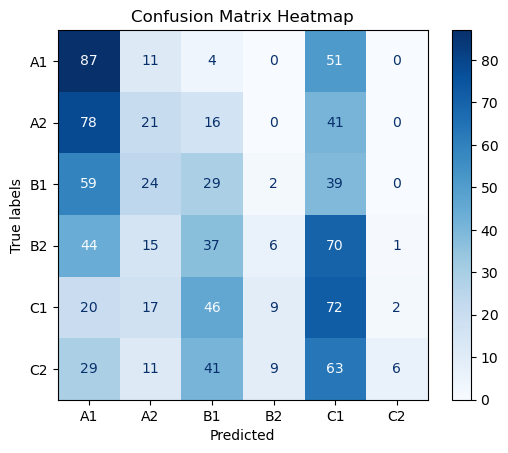

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='g')
plt.xlabel('Predicted')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


### Train on the full training data, test on the unlabelled test data

In [50]:
# split your data into features (X) and target variable (y)
X = training['processed_sentence']
y = training['difficulty']

# define test data
X_full_test = test['processed_sentence']

# vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_full_train_tfidf = tfidf.fit_transform(X)
X_full_test_tfidf = tfidf.transform(X_full_test)

In [51]:
# Train your classification algorithm
decision_tree_classifier.fit(X_full_train_tfidf, y)

DecisionTreeClassifier(max_depth=10, random_state=123)

In [52]:
# predict using the trained model on the scaled test data
y_full_pred_dt = decision_tree_classifier.predict(X_full_test_tfidf)

In [53]:
# display y_full_pred values for each X
df_full_pred_dt = pd.DataFrame({'id': X_full_test.index, 'difficulty': y_full_pred_dt})
df_full_pred_dt

,id,difficulty
0,0,B1
1,1,A2
2,2,A2
3,3,A1
4,4,C1
...,...,...
1195,1195,B2
1196,1196,B1
1197,1197,B2
1198,1198,C1


### Export the df as csv for kagle submission

In [55]:
# export the dataframe as csv
df_full_pred_dt.to_csv("df_dt_lemma.csv", index=False)

# accuracy score based on kagel submission: [df_dt.csv : 0.390 ; df_dt_lemma.csv : 0.271

# KNN 

kNN (k-Nearest Neighbors) classifies by majority vote of the nearest k points. No model training, only distance calculations. Example: Recommending similar products.

### Train on 80% of training data, test on 20% of training data

In [59]:
#Define X and y
X = training['processed_sentence']
y = training['difficulty']
#Define random seed
random_seed = 123

#Split training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# vectorization
#french_stop_words = stopwords.words('french')
#tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=french_stop_words)
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize the kNN classifier
knn_classifier = KNeighborsClassifier()
# Train the kNN classifier on the training data
knn_classifier.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

In [60]:
# Make predictions on the test data
y_pred_knn = knn_classifier.predict(X_test_tfidf)

### Evaluate the Model

**General description** 
Precision: Ratio of correctly predicted positive observations to total predicted positives.\
Recall Rate: Ratio of correctly predicted positives to actual positives. \
F1 Score: Harmonic mean of precision and recall. \
Accuracy: Ratio of correctly predicted observations to total observations.

In [63]:
#Calculate Precision
precision_knn = precision_score(y_test, y_pred_knn, average='macro')
#Calculate recall score
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
# Calculate F1 score
f1_knn = f1_score(y_test, y_pred_knn, average='macro')
# Calculate accuracy score
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"precision:{precision_knn:.2f}")
print(f"recall rate: {recall_knn:.2f}")
print(f"F1 score: {f1_knn:.2f}")
print(f"accuracy: {accuracy_knn:.2f}")

precision:0.31
recall rate: 0.21
F1 score: 0.16
accuracy: 0.21


In [64]:
# display the classification report
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

          A1       0.18      0.84      0.30       153
          A2       0.24      0.15      0.19       156
          B1       0.17      0.07      0.09       153
          B2       0.44      0.10      0.16       173
          C1       0.37      0.07      0.11       166
          C2       0.50      0.06      0.10       159

    accuracy                           0.21       960
   macro avg       0.31      0.21      0.16       960
weighted avg       0.32      0.21      0.16       960



<Figure size 800x600 with 0 Axes>

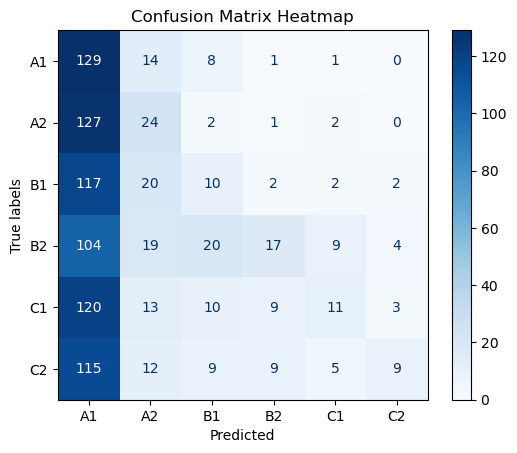

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_knn)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='g')
plt.xlabel('Predicted')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


### Train on the full training data, test on the unlabelled test data

In [67]:
# split your data into features (X) and target variable (y)
X = training['processed_sentence']
y = training['difficulty']

# define test data
X_full_test = test['processed_sentence']

# vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_full_train_tfidf = tfidf.fit_transform(X)
X_full_test_tfidf = tfidf.transform(X_full_test)

In [68]:
# Train your classification algorithm
knn_classifier.fit(X_full_train_tfidf, y)

KNeighborsClassifier()

In [69]:
# predict using the trained model on the scaled test data
y_full_pred_knn = knn_classifier.predict(X_full_test_tfidf)

In [70]:
# display y_full_pred values for each X
df_full_pred_knn = pd.DataFrame({'id': X_full_test.index, 'difficulty': y_full_pred_knn})
df_full_pred_knn

,id,difficulty
0,0,C1
1,1,A1
2,2,A1
3,3,A1
4,4,A1
...,...,...
1195,1195,A1
1196,1196,A2
1197,1197,A1
1198,1198,C1


### Export the df as csv for kagle submission

In [72]:
# export the dataframe as csv
df_full_pred_knn.to_csv("df_knn_lemma.csv", index=False)

# accuracy score based on kagel submission: [df_knn.csv : 0.175 ; df_knn_lemma.csv : 0.233

# Random Forest

Random Forest is an ensemble of decision trees, averaging predictions to improve accuracy and control overfitting. Each tree uses a subset of data. Example: Detecting fraudulent financial transactions.

### Train on 80% of training data, test on 20% of training data

In [76]:
#Define X and y
X = training['processed_sentence']
y = training['difficulty']
#Define random seed
random_seed = 123

#Split training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Vectorization
#french_stop_words = stopwords.words('french')
#tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=french_stop_words)
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#Train the classifier
classifier_rf = RandomForestClassifier(random_state=123)
#Fit to the train data
classifier_rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=123)

In [77]:
#Predict with Random Forest
y_pred_rf = classifier_rf.predict(X_test_tfidf)

### Evaluate the Model

**General description** 
Precision: Ratio of correctly predicted positive observations to total predicted positives.\
Recall Rate: Ratio of correctly predicted positives to actual positives. \
F1 Score: Harmonic mean of precision and recall. \
Accuracy: Ratio of correctly predicted observations to total observations.

In [80]:
#Calculate Precision
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
#Calculate recall score
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
# Calculate F1 score
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
# Calculate accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"precision:{precision_rf:.2f}")
print(f"recall rate: {recall_rf:.2f}")
print(f"F1 score: {f1_rf:.2f}")
print(f"accuracy: {accuracy_rf:.2f}")

precision:0.39
recall rate: 0.38
F1 score: 0.36
accuracy: 0.37


In [81]:
# Display the classification report
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

          A1       0.33      0.78      0.47       153
          A2       0.35      0.28      0.31       156
          B1       0.39      0.32      0.35       153
          B2       0.31      0.26      0.28       173
          C1       0.46      0.25      0.32       166
          C2       0.52      0.38      0.44       159

    accuracy                           0.37       960
   macro avg       0.39      0.38      0.36       960
weighted avg       0.39      0.37      0.36       960



<Figure size 800x600 with 0 Axes>

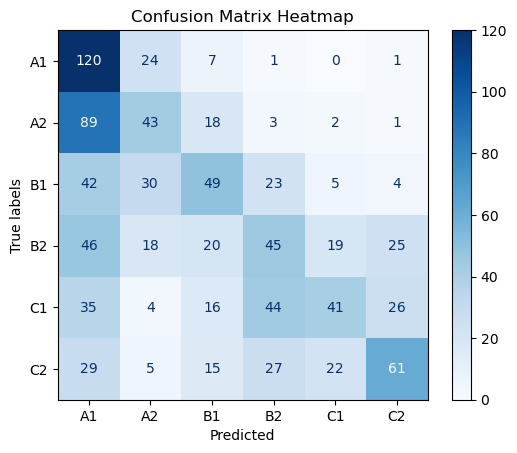

In [82]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='g')
plt.xlabel('Predicted')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


### Train on the full training data, test on the unlabelled test data

In [84]:
# split your data into features (X) and target variable (y)
X = training['processed_sentence']
y = training['difficulty']

# define test data
X_full_test = test['processed_sentence']

# vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_full_train_tfidf = tfidf.fit_transform(X)
X_full_test_tfidf = tfidf.transform(X_full_test)

In [85]:
# Train your classification algorithm
classifier_rf.fit(X_full_train_tfidf, y)

RandomForestClassifier(random_state=123)

In [86]:
# predict using the trained model on the scaled test data
y_full_pred_rf = classifier_rf.predict(X_full_test_tfidf)

In [87]:
# display y_full_pred values for each X
df_full_pred_rf = pd.DataFrame({'id': X_full_test.index, 'difficulty': y_full_pred_rf})
df_full_pred_rf

,id,difficulty
0,0,B1
1,1,B1
2,2,A1
3,3,A1
4,4,C2
...,...,...
1195,1195,B2
1196,1196,A2
1197,1197,C2
1198,1198,A1


### Export the df as csv for kagle submission

In [89]:
# export the dataframe as csv
df_full_pred_rf.to_csv("df_rf_lemma.csv", index=False)

# accuracy score based on kagel submission: [df_rf.csv :  ; df_rf_lemma.csv : 0.391

# Exploring data

In [94]:
#Identifiying most repeated words
#max_word = tf_idf.sum(axis=0).sort_values(ascending=False)
#max_word.head(20)

In [ ]:
#merged = pd.merge(training, tf_idf, left_index=True, right_index=True)
#merged.head(5)

In [ ]:
#difficulties = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
#for i in difficulties:
#    temp_df = merged[merged['difficulty']=='i']
#    temp_df = temp_df.drop(columns=['id', 'sentence', 'difficulty'])
#    max_word = temp_df.sum(axis=0).sort_values(ascending=False)
#    print(i, max_word.head(10))

In [ ]:
#from nltk.tokenize import word_tokenize
#nltk.download('punkt')

#parameters = training.copy()

# Define a function to count words and numbers
#def count_elements(text):
#    # Tokenize the sentence
#    tokens = word_tokenize(text)
#    # Count tokens
#    return len(tokens)

# Step 4: Apply the function to the 'sentence' column
#parameters['word_count'] = parameters['sentence'].apply(count_elements)

#parameters.head(5)


In [ ]:
#word_count = parameters.groupby('difficulty')['word_count'].mean()
#word_count

# Other techniques

# Compare accuracies between the models